# Energy-Magnitude scale and b-value paper

The goal here is to fully explore the DSN catalog, understand data loss, compute ML and ME and the most meaningful ways, work out scales for each subclass, compute station corrections (might need to compute network magnitude from mean as well as median station magnitude).

With some general station corrections figured out, might also then have a good basis for computing locations based on station-corrected ASL.

Can also study the b-value and magnitude of completeness of all events and by subclass for different periods of the eruption, and plot counts above that magnitude of completeness.

In the write-up, discuss motivations to catalog swarms, tremor, dome collapse signals, lahars, explosions. Critique the practice of summing magnitudes. Implementation at MVO. Reversal of amplitude -> ML -> energy. Energy can be computed directly. And it the only parameter that can be physically summed. Compare it with reduced displacement too, but point out how it is better, since Joules more meaningful than cm^2. (Later study could compare with VEI and ash column height).

I might also want to run detections on each signal, ensure the twin (or duration) parameter exists, and compute a coda duration magnitude according to: Mc = 2.0 log10(duration_in_secs) + 3.5e-6 (dist_in_m) - 0.87

<b>Ideally this would be published after a paper on recovering the entire DSN continuous and event datasets, which could also explore merging the 2 datasets</b>.

<b>I also need to publish advances at MVO paper, which could reconstruct the systems ran, the datasets, even the website with all the plots and alarms. Could basically run the system on data archive between certain time range</b>

All datasets could also have DOIs added. As should all codes. So I can cite them.

I may also want to publish <b>a paper on real-time monitoring products</b> first:
* IceWeb 1996/1998, improving on SSAM/RSAM. If the AEC spectrograms are not running anymore, migrate them to newton. Pensive. My new IceWebPy.
* Energy magnitude 2000
* Amplitude location 1996/2000
* banded tremor detection
* escalating tremor alarm system
* Event spectrograms 2000
* Swarm alarm system 2009 & real time location & optimization project & escalation alarms 
* Sausage plot 2011
* Summarize other tools by other people, e.g. RESA, redpy, diana’s tremor detector, 
* Go over origin of each idea, goal of enhancing real time catalog & expand it to include other signals.
* seisan2pandas
* codes to convert SUDS data?
* provide codes for everything in gismo and / or obspy. new obspy codes & integration could be separate paper
* cover earlier developments too: event detection, rsam, ssam, helicorders, event vs continuous products. does webobs have realtime tools?
* create a repository or webpage linking in other codes for community & link back to my original inspiration at mvo in 1996
* future: Ml, 3-c wave detection & classification, better real time location

<b>Another paper is to merge the ASN and DSN catalogs. Also need to run MachineLearning on ASN catalog. So could have one MachineLearning paper on each network. Just use data from the era before April 1, 2008, so UWI/SRC/MVO cannot complain</b>

# 1. Plot cumulative event counts and cumulative magnitudes

In [241]:
import pandas as pd
from obspy.core import UTCDateTime

full_catalog_csv = '/Volumes/shareddrive/thompsong/MachineLearning/MVOE_/original/MVOE_11_master_catalog_original2.csv'
full_catalog_df = pd.read_csv(full_catalog_csv)
full_catalog_df.to_pickle('MVOE_catalog_original.pd')

## 1.1 Explore the catalog in different ways

In [242]:
full_catalog_df = pd.read_pickle('MVOE_catalog_original.pd')
count_s = len(full_catalog_df.index)
print('Total number of S-files %d' % len(full_catalog_df.index))

def remove_events_without_DSN_wavfile(df):
    df2 = df[df['DSN_exists']==True]
    return df2

with_wavfile_df = remove_events_without_DSN_wavfile(full_catalog_df)
print('Total number S-files with DSN wavfile %d' % len(with_wavfile_df.index))

with_filetime_df = with_wavfile_df.dropna(subset=['filetime'])
print('Total number S-files with non-null filetime %d' % len(with_filetime_df.index))

### More detailed counts follow

sfiles_without_wavfiles = full_catalog_df[full_catalog_df['ASN_wavfile'].isnull()]
sfiles_without_wavfiles = sfiles_without_wavfiles[sfiles_without_wavfiles['DSN_wavfile'].isnull()]
count_s_without_w = len(sfiles_without_wavfiles)
print(count_s_without_w, 's-files exist that do not point to at least one wavfile')
print('this leaves a total of %d s-files that do point to at least one wavfile' % (count_s - count_s_without_w))
#display(sfiles_without_wavfiles)

asn_wavfile_df = full_catalog_df[full_catalog_df['ASN_wavfile'].isnull()==False]
count_asn_wavfile = len(asn_wavfile_df)
print(count_asn_wavfile, 's-files point to an ASN wavfile')

asn_exists_df = full_catalog_df[full_catalog_df['ASN_exists']==True]
count_asn_exists = len(asn_exists_df)
print(count_asn_exists, 's-files point to an ASN wavfile that exists. So ',count_asn_wavfile - count_asn_exists, ' ASN wavfiles are missing')

dsn_wavfile_df = full_catalog_df[full_catalog_df['DSN_wavfile'].isnull()==False]
count_dsn_wavfile = len(dsn_wavfile_df)
print(count_dsn_wavfile, 's-files point to an DSN wavfile')

dsn_exists_df = full_catalog_df[full_catalog_df['DSN_exists']==True]
count_dsn_exists = len(dsn_exists_df)
print(count_dsn_exists, 's-files point to an DSN wavfile that exists. So ',count_dsn_wavfile - count_dsn_exists, ' DSN wavfiles are missing')

asn_wavfile_without_dsn_wavfile_df = full_catalog_df[full_catalog_df['ASN_wavfile'].isnull()==False]
asn_wavfile_without_dsn_wavfile_df = asn_wavfile_without_dsn_wavfile_df[asn_wavfile_without_dsn_wavfile_df['DSN_wavfile'].isnull()]
count_asn_wavfile_without_dsn_wavfile = len(asn_wavfile_without_dsn_wavfile_df)
print(count_asn_wavfile_without_dsn_wavfile, 's-files point to an ASN wavfile, but not a DSN wavfile')

asn_exists_without_dsn_exists_df = full_catalog_df[full_catalog_df['ASN_exists']==True]
asn_exists_without_dsn_exists_df = asn_exists_without_dsn_exists_df[asn_exists_without_dsn_exists_df['DSN_exists']==False]
count_asn_exists_without_dsn_exists = len(asn_exists_without_dsn_exists_df)
print(count_asn_exists_without_dsn_exists, 's-files point to an existing ASN wavfile, but not an existing DSN wavfile')

dsn_wavfile_without_asn_wavfile_df = full_catalog_df[full_catalog_df['DSN_wavfile'].isnull()==False]
dsn_wavfile_without_asn_wavfile_df = dsn_wavfile_without_asn_wavfile_df[dsn_wavfile_without_asn_wavfile_df['ASN_wavfile'].isnull()]
count_dsn_wavfile_without_asn_wavfile = len(dsn_wavfile_without_asn_wavfile_df)
print(count_dsn_wavfile_without_asn_wavfile, 's-files point to an DSN wavfile, but not a ASN wavfile')

dsn_exists_without_asn_exists_df = full_catalog_df[full_catalog_df['DSN_exists']==True]
dsn_exists_without_asn_exists_df = dsn_exists_without_asn_exists_df[dsn_exists_without_asn_exists_df['ASN_exists']==False]
count_dsn_exists_without_asn_exists = len(dsn_exists_without_asn_exists_df)
print(count_dsn_exists_without_asn_exists, 's-files point to an existing DSN wavfile, but not an existing ASN wavfile')

miniseed_c_exists_df = dsn_wavfile_df[dsn_wavfile_df['corrected_DSN_mseed'].isnull()==False]
print('Of the %d S-files that point to existing DSN wavfiles, %d have miniseed_c files' % (count_dsn_exists,len(miniseed_c_exists_df)))
print('I guess this means we lost %d during the seisan2pandas process' % (count_dsn_exists - len(miniseed_c_exists_df)))
with_filetime_df = with_wavfile_df.dropna(subset=['filetime'])
print('Total number S-files with non-null filetime %d' % len(with_filetime_df.index))
print('This is because we got filetime from processing a DSN wavfile successfully')

Total number of S-files 231951
Total number S-files with DSN wavfile 209761
Total number S-files with non-null filetime 209135
231 s-files exist that do not point to at least one wavfile
this leaves a total of 231720 s-files that do point to at least one wavfile
41234 s-files point to an ASN wavfile
35994 s-files point to an ASN wavfile that exists. So  5240  ASN wavfiles are missing
213582 s-files point to an DSN wavfile
209761 s-files point to an DSN wavfile that exists. So  3821  DSN wavfiles are missing
18138 s-files point to an ASN wavfile, but not a DSN wavfile
15763 s-files point to an existing ASN wavfile, but not an existing DSN wavfile
190486 s-files point to an DSN wavfile, but not a ASN wavfile
189530 s-files point to an existing DSN wavfile, but not an existing ASN wavfile
Of the 209761 S-files that point to existing DSN wavfiles, 209135 have miniseed_c files
I guess this means we lost 626 during the seisan2pandas process
Total number S-files with non-null filetime 209135


Summary:
* We have 213,206 S-files, but only 191,182 are linked to existing DSN WAV files. 
* We lost 3,656 DSN WAV files over time due to imperfections in data archiving, and for a paper we should examine the time distribution of these more closely. 
* Some of these lost WAV files might be recoverable from the continuous data archive.
* We will have lost events too, due to downtime of the data acquisition system, before event triggering could take place, but there is no way to count these.
* We have lost another 624 events because something went wrong in the 00 seisan to pandas process - possibly because the traces were all bad. Should be further explored.
* In total, we have 190,558 DSN events we can use from an initial set of 194,838. 
* <b>Currently the catalog only goes from 1996/10/23 to 2006/08/31 as shown below. I must have used a catalog before seisan2pandas had completed running, because I believe I have up to 2008/08. I should stop at 2008/03/31 though, since this is the BGS era, and SRU cannot have any claim on this.</b>

In [243]:
import datetime as dt
def wavfile2filetime(wavfile):
    if not isinstance(wavfile, str):
        return None
    wavbase = os.path.basename(wavfile)
    _x = wavbase.split('.')[0]
    _x = _x.split('-')
    if len(_x)==5:
        yyyy = _x[0]
        mm = _x[1]
    elif len(_x)==4:
        yy = _x[0][0:2]
        if yy[0]=='9':
            yyyy = '19' + yy
        elif yy[0]=='2':
            yyyy = '20' + yy
        mm = _x[0][2:4]
    dd = _x[-3]
    HH = _x[-2][0:2]
    MI = _x[-2][2:4]
    SS = _x[-1][0:2]
    #print(yyyy,mm,dd,HH,MI,SS)
    this_dt = dt.datetime(int(yyyy), int(mm), int(dd), hour=int(HH), minute=int(MI), second=int(SS))
    this_utc = UTCDateTime(this_dt)
    return this_utc.isoformat()

def find_earliest_and_latest_events(df2):
    df = df2.copy()
    df['filetime2'] = [wavfile2filetime(x) for x in df['DSN_wavfile']]
    df = df.dropna(subset=['filetime2'])
    some_cols_df = df[['DSN_wavfile','filetime2']].sort_values(by ='filetime2', ascending = True);   
    print('Earliest events:\n',some_cols_df.head())
    print('Latest events:\n',some_cols_df.tail())

find_earliest_and_latest_events(full_catalog_df)

Earliest events:
                       DSN_wavfile            filetime2
141312  9610-23-1608-00S.MVO_21_1  1996-10-23T16:08:00
141313  9610-23-2007-11S.MVO_21_1  1996-10-23T20:07:11
141314  9610-23-2235-49S.MVO_21_1  1996-10-23T22:35:49
141315  9610-23-2342-17S.MVO_21_1  1996-10-23T23:42:17
141316  9610-23-2351-04S.MVO_21_1  1996-10-23T23:51:04
Latest events:
                           DSN_wavfile            filetime2
145441  2008-10-18-0957-08S.MVO___031  2008-10-18T09:57:08
145442  2008-10-18-1047-32S.MVO___031  2008-10-18T10:47:32
145443  2008-10-18-1525-57S.MVO___031  2008-10-18T15:25:57
145444  2008-10-18-1553-39S.MVO___031  2008-10-18T15:53:39
145445  2008-10-18-1729-22S.MVO___031  2008-10-18T17:29:22


In [260]:
miniseed_c_exists_df['num_traces'].sum()

1859161.0

## 1.2 Counts plots

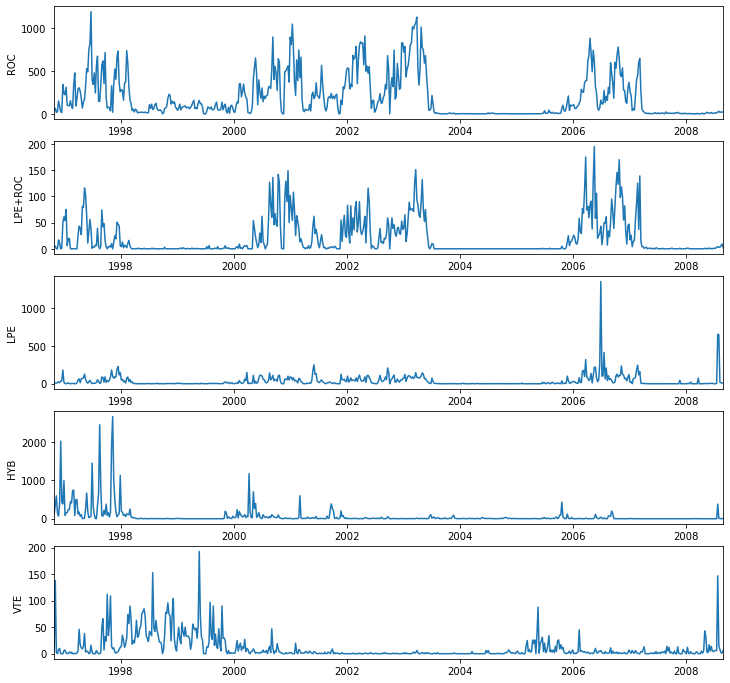

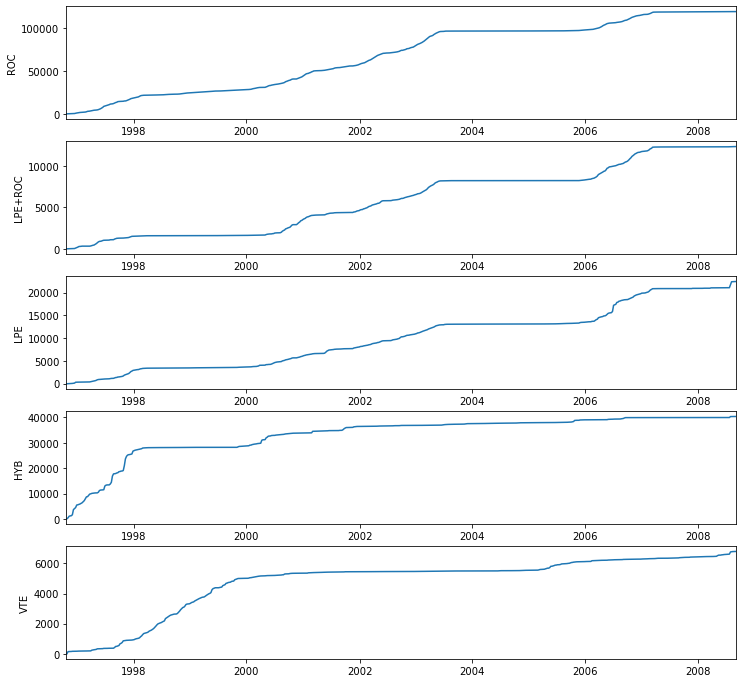

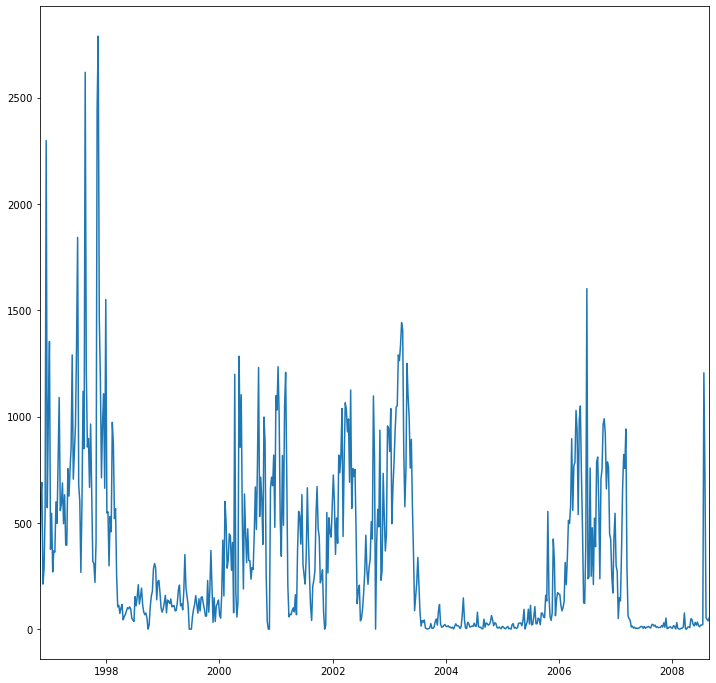

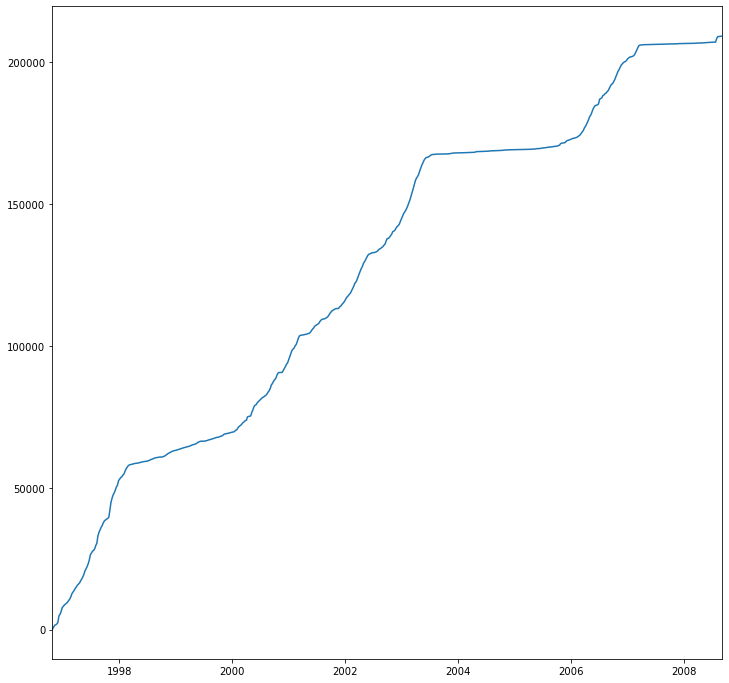

In [259]:
def plot_counts_by_subclass(df2, interval='W', cumulative=False):
    # interval can be 'D', 'W', 'M'
    fig = plt.figure(figsize=[12,12])
    labels = ['ROC', 'LPE+ROC', 'LPE', 'HYB', 'VTE']
    df = df2.copy()
    df['count']=1
    xmin = df['datetime'].min()
    xmax = df['datetime'].max()
    ax = [None] * len(labels)
    for i, subclass in enumerate(['r','e','l','h','t']):
        df_subclass = df[df['subclass']==subclass]
        by_interval = df_subclass.groupby(pd.Grouper(key='datetime', axis=0, freq=interval)).sum()
        if i>0:
            ax[i] = fig.add_subplot(len(labels), 1, i+1, sharex=ax[0])
        else:
            ax[i] = fig.add_subplot(len(labels), 1, i+1)
        if cumulative:
            ax[i].plot(by_interval.index, by_interval['count'].cumsum())
        else:
            ax[i].plot(by_interval.index, by_interval['count'])
        ax[i].xaxis_date()
        ax[i].set_ylabel(labels[i])

        ax[i].set_xlim(xmin, xmax)
        
def plot_counts_overall(df2, interval='W', cumulative=False):
    # interval can be 'D', 'W', 'M'
    fig = plt.figure(figsize=[12,12])
    df = df2.copy()
    df['count']=1
    by_interval = df.groupby(pd.Grouper(key='datetime', axis=0, freq=interval)).sum()
    ax = fig.add_subplot(1, 1, 1)
    if cumulative:
        ax.plot(by_interval.index, by_interval['count'].cumsum())
    else:
        ax.plot(by_interval.index, by_interval['count'])
    ax.xaxis_date()  
    plt.autoscale(enable=True, axis='x', tight=True)
    
def filetime2UTCDateTime(x): # Not sure this function is needed if I use correct dataframe
    if isinstance(x, str):
        return UTCDateTime(x)
    else:
        return UTCDateTime(0) 
    
def add_datetime_cols(df):    
    df['utcdatetime'] = [filetime2UTCDateTime(x) for x in df['filetime']] # use f(x) here if some filetime null
    df['datetime'] = [x.datetime for x in df['utcdatetime']]
    df['date'] = [x.date for x in df['datetime']]    

if not 'date' in miniseed_c_exists_df.columns: 
    add_datetime_cols(miniseed_c_exists_df)      
plot_counts_by_subclass(miniseed_c_exists_df, interval='W')
plot_counts_by_subclass(miniseed_c_exists_df, cumulative=True)
plot_counts_overall(miniseed_c_exists_df)  
plot_counts_overall(miniseed_c_exists_df, cumulative=True)    

In [270]:
def count_events(df):
    df_by_subclass = df.groupby("new_subclass")
    count_df = df_by_subclass['filetime'].count()
    return count_df
    
#count_events(full_catalog_df)
count_df = count_events(miniseed_c_exists_df)
display(count_df)

subclasses = ['r', 'e', 'l', 'h', 't', 'g', 'R', 'n']

count_df2 = pd.DataFrame(columns=['Count'])
count_df2.loc['ROC', 'Count'] = count_df['r']
count_df2.loc['LPE-ROC', 'Count'] = count_df['e']
count_df2.loc['LPE', 'Count'] = count_df['l']
count_df2.loc['HYB', 'Count'] = count_df['h']
count_df2.loc['VTE', 'Count'] = count_df['t']
count_df2.loc['REG', 'Count'] = count_df['R']
count_df2.loc['TELESEISM', 'Count'] = count_df['D']
count_df2.loc['other', 'Count'] = len(miniseed_c_exists_df)-count_df2['Count'].sum()
display(count_df2)

new_subclass
1             2
2            12
3            28
D            10
M             8
R           116
U            14
V             1
e         12344
g          1494
h         40375
h*            1
hl          178
l         22451
m            47
n          5896
r        118954
rf            2
s            86
swarm         1
t          6793
u           305
x            11
Name: filetime, dtype: int64

,Count
ROC,118954
LPE-ROC,12344
LPE,22451
HYB,40375
VTE,6793
REG,116
TELESEISM,10
other,8092


## 1.3 Cumulative magnitude plots? 

The following functions are for counts. Need to modify for cumulative magnitude, by adding Eseismic column.

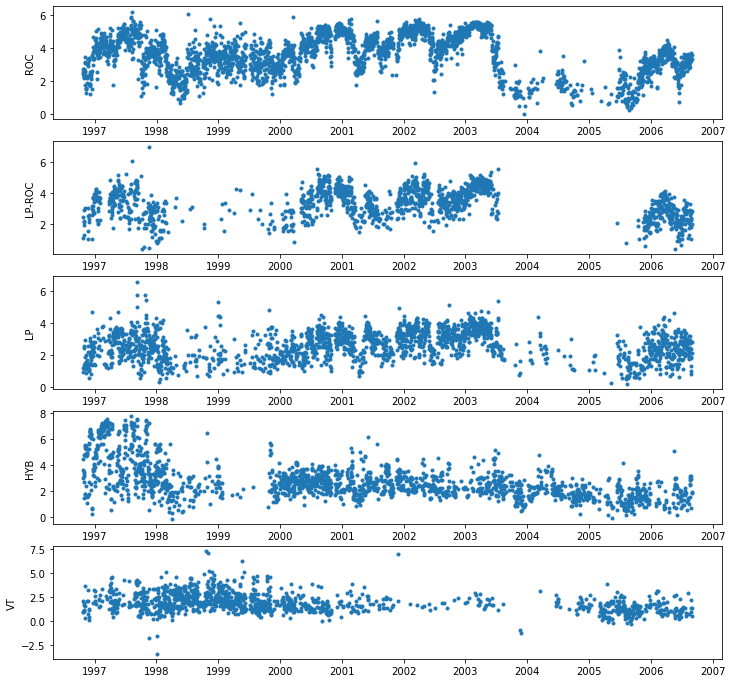

In [238]:

def plot_cummag_by_subclass(df2, interval='W', cumulative=False):
    # interval can be 'D', 'W', 'M'
    fig = plt.figure(figsize=[12,12])
    labels = ['ROC', 'LP-ROC', 'LP', 'HYB', 'VT']
    df = df2.copy()
    df['count']=1
    
    for i, subclass in enumerate(['r','e','l','h','t']):
        df_subclass = df[df['subclass']==subclass]
        by_interval = df_subclass.groupby(pd.Grouper(key='datetime', axis=0, freq=interval)).sum()
        ax = fig.add_subplot(len(labels), 1, i+1)
        if cumulative:
            ax.plot(by_interval.index, by_interval['Eseismic'].cumsum())
        else:
            # ME = log10(Eseismic)/1.66 - 2.18,  based on VT fit of ME to ML (with ML corrected by 0.3 units)
            by_interval['energy-mag'] = np.log10(by_interval['Eseismic']/1.66) - 2.18
            ax.plot(by_interval.index, by_interval['energy-mag'], '.')
            
        ax.xaxis_date()
        ax.set_ylabel(labels[i])
        
def plot_cummag_overall(df2, interval='W', cumulative=False):
    # interval can be 'D', 'W', 'M'
    fig = plt.figure(figsize=[12,12])
    df = df2.copy()
    df['count']=1
    by_interval = df.groupby(pd.Grouper(key='datetime', axis=0, freq=interval)).sum()
    ax = fig.add_subplot(1, 1, 1)
    if cumulative:
        ax.plot(by_interval.index, by_interval['Eseismic'].cumsum())
    else:
        ax.plot(by_interval.index, by_interval['Eseismic'])
    ax.xaxis_date()  
    
add_datetime_cols(miniseed_c_exists_df)      
plot_cummag_by_subclass(miniseed_c_exists_df, interval='D')
#plot_cummag_by_subclass(miniseed_c_exists_df, cumulative=True)
#plot_cummag_overall(miniseed_c_exists_df)  
#plot_cummag_overall(miniseed_c_exists_df, cumulative=True) 

So if we now want to count events by subclass, we can do that in three different ways. 
(1) plot all events, regardless of whether they have existing Seisan WAV or corrected Miniseed files (fulldf)
(2) plot only those with Seisan WAV files (df)
(3) plot only those with MiniSEED files (df2)

In [ ]:
def f(x):
    if isinstance(x, str):
        return UTCDateTime(x)
    else:
        print(x)
        print(type(x))
        return UTCDateTime(0) # Bad filetime is replaced by UTCDateTime(0), which is 1970-01-01 00:00:00

In [71]:
def add_datetime_cols(df):    
    df['utcdatetime'] = [UTCDateTime(x) for x in df['filetime']] # use f(x) here if some filetime null
    df['datetime'] = [x.datetime for x in df['utcdatetime']]
    df['date'] = [x.date for x in df['datetime']]
    
add_datetime_cols(df2)

/Users/gt/opt/anaconda3/envs/AAA/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/gt/opt/anaconda3/envs/AAA/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/gt/opt/anaconda3/envs/AAA/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [72]:
print(df2.columns)

Index(['index', 'ASN_exists', 'ASN_wavfile', 'DSN_exists', 'DSN_wavfile',
       'Eseismic', 'Fs', 'R', 'bandratio_[0.8_4.0_16.0]',
       'bandratio_[1.0_6.0_11.0]', 'bw_max', 'bw_min', 'calib',
       'corrected_ASN_mseed', 'corrected_DSN_mseed', 'day', 'elev', 'energy',
       'filetime', 'hour', 'kurtosis', 'lat', 'lon', 'magA', 'magE', 'medianF',
       'minute', 'month', 'noise_level', 'num_gaps', 'num_traces', 'path',
       'peakA', 'peakF', 'peakamp', 'peaktime', 'percent_availability',
       'quality', 'sample_lower_quartile', 'sample_max', 'sample_mean',
       'sample_median', 'sample_min', 'sample_rms', 'sample_stdev',
       'sample_upper_quartile', 'second', 'sfile', 'signal_level', 'skewness',
       'snr', 'subclass', 'twin', 'year', 'D', 'r', 'e', 'l', 'h', 't',
       'new_subclass', 'weight', 'checked', 'split', 'delete', 'ignore',
       'utcdatetime', 'datetime', 'date'],
      dtype='object')


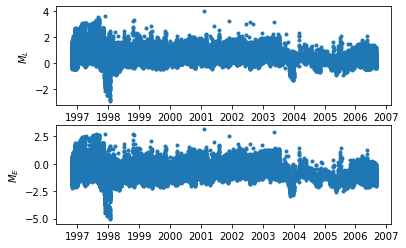

In [85]:
import matplotlib.pyplot as plt
df2.set_index('datetime')
df2.sort_index()

# can plot single columns like this
plt.figure()
plt.subplot(2,1,1)
plt.plot_date(df2['datetime'],df2['magA'], marker='.');
plt.ylabel('$M_{L}$');

plt.subplot(2,1,2)
plt.plot_date(df2['datetime'],df2['magE'], marker='.');
plt.ylabel('$M_{E}$');

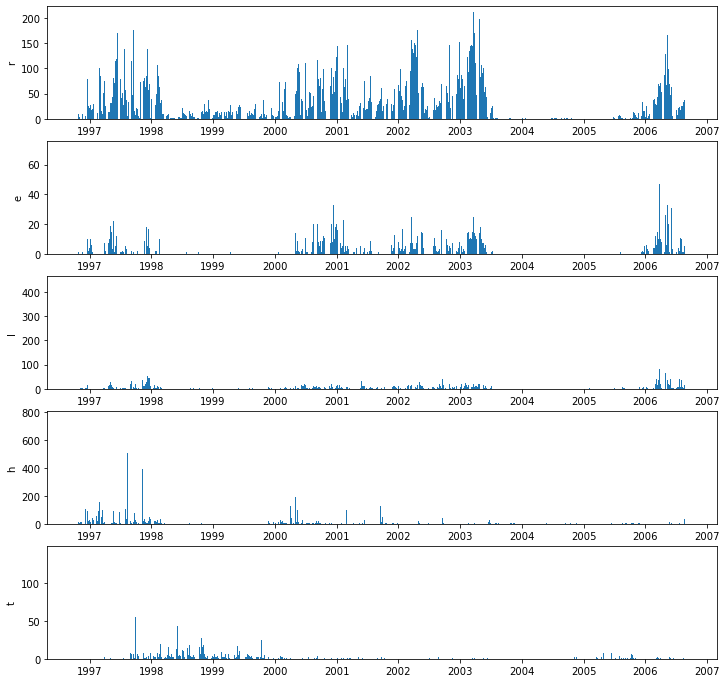

In [120]:
#df_grouped = (df2.groupby(['date', 'subclass']).size().reset_index(name="count"))
#print(df_grouped)
fig = plt.figure(figsize=[12,12])
for i, subclass in enumerate(['r','e','l','h','t']):
    df_subclass = df2[df2['subclass']==subclass]
    by_day = df_subclass.groupby(pd.Grouper(key='datetime', axis=0, freq='D')).sum()
    #display(by_month)
    #by_day = df_subclass.groupby(['date'].size().reset_index(name="count"))
    ax = fig.add_subplot(5, 1, i+1)
    #plt.plot_date(by_month.index,by_month['DSN_exists'], marker='.');
    ax.bar(by_day.index,by_day['DSN_exists'])
    ax.xaxis_date()
    ax.set_ylabel(subclass)

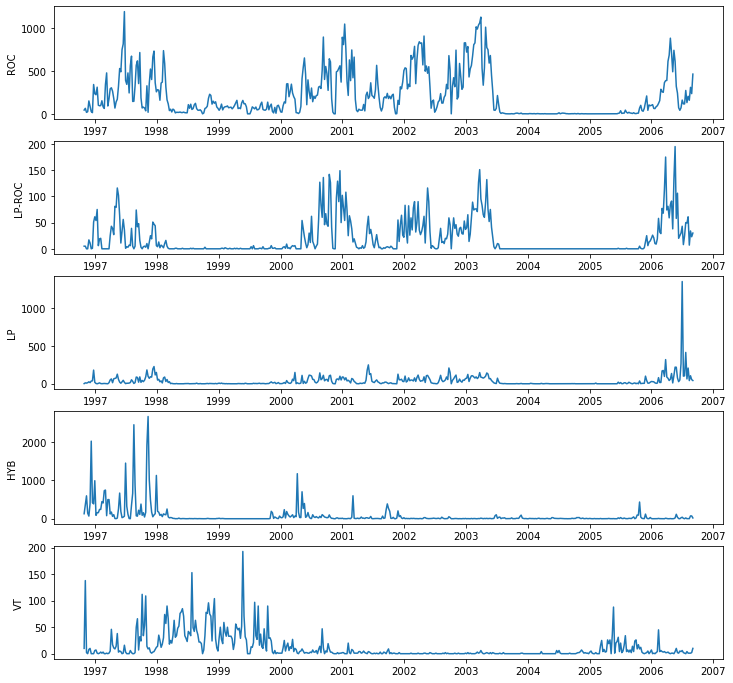

In [136]:
fig = plt.figure(figsize=[12,12])
labels = ['ROC', 'LP-ROC', 'LP', 'HYB', 'VT']
for i, subclass in enumerate(['r','e','l','h','t']):
    df_subclass = df2[df2['subclass']==subclass]
    by_day = df_subclass.groupby(pd.Grouper(key='datetime', axis=0, freq='W')).sum()
    #display(by_month)
    #by_day = df_subclass.groupby(['date'].size().reset_index(name="count"))
    ax = fig.add_subplot(5, 1, i+1)
    #plt.plot_date(by_month.index,by_month['DSN_exists'], marker='.');
    ax.plot(by_day.index, by_day['DSN_exists'])
    ax.xaxis_date()
    ax.set_ylabel(labels[i])

In [123]:
by_day.index[-1]

Timestamp('2006-08-31 00:00:00', freq='D')

# 2. Magnitude Analysis: ML vs ME
In this section, we analyze the ML and ME estimates. Our goal is to find a relationship that works for VT events, and then see if other event types have the same behaviour. We can also see if it works the same for different stations.

In [80]:
catalogcsv = '/Volumes/shareddrive/thompsong/MachineLearning/MVOE_/original/MVOE_11_master_catalog_original.csv'
cat = pd.read_csv(catalogcsv)
cat.to_pickle('MVOE_catalog_original.pd')
print(cat.columns)

/Users/gt/opt/anaconda3/envs/AAA/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['index', 'ASN_exists', 'ASN_wavfile', 'DSN_exists', 'DSN_wavfile',
       'Eseismic', 'Fs', 'R', 'bandratio_[0.8_4.0_16.0]',
       'bandratio_[1.0_6.0_11.0]', 'bw_max', 'bw_min', 'calib',
       'corrected_ASN_mseed', 'corrected_DSN_mseed', 'day', 'elev', 'energy',
       'filetime', 'hour', 'kurtosis', 'lat', 'lon', 'magA', 'magE', 'medianF',
       'minute', 'month', 'noise_level', 'num_gaps', 'num_traces', 'path',
       'peakA', 'peakF', 'peakamp', 'peaktime', 'percent_availability',
       'quality', 'sample_lower_quartile', 'sample_max', 'sample_mean',
       'sample_median', 'sample_min', 'sample_rms', 'sample_stdev',
       'sample_upper_quartile', 'second', 'sfile', 'signal_level', 'skewness',
       'snr', 'subclass', 'twin', 'year', 'D', 'r', 'e', 'l', 'h', 't',
       'new_subclass', 'weight', 'checked', 'split', 'delete', 'ignore'],
      dtype='object')


## 2.1 Fitting the whole dataset

Here we just fit the whole dataset, to demonstrate the methodology.

There are a few things we will want to do in a paper: "An energy-magnitude scale for all volcano-seismic events". We will first want to demonstrate how we take the Hanks and Kanamori moment tensor magnitude calculation, and because moment tensor has units of Joules, exert the assumption that we can use a similar formulation for magnitude. Except, in a way, we really do not need that. We just need to compute ML, in the normal way, and then Eseismic from Boatwright (or Johnson and Aster 2005), and then create linear regressions for each different event class, to see how they behave. And ideally, we would compute the overall average shapes (envelopes) of these signals too.

Since ML is only directly applicable to VT events, we can use the mapping between ML and Eseismic for VT's to set the constants we need for computing ME from Eseismic, to minimize misfit between ML and ME for VTs. And then we can use this improved ME (we will label it ME2 here) and see how it compares to MA for different event types.

I erroneously had b=0.15 in Mlrichter, when the standard number is b=-0.15. So my ML values are too high by 0.30. But I need to work out correct a and b values for Montserrat, and station corrections g.

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
cat = pd.read_pickle('MVOE_catalog_original.pd')
magcat = cat[cat['magA'].notna()] # remove rows with null/NaN values for magnitudes
magcat['magA']=magcat['magA']-0.3 # correction for having wrong value for b

def fit_ME_to_ML(x, y): # fit_ME_to_ML(magA, magE)
    print('Got %d events' % len(x))
    
    # plot the whole dataset
    plt.figure()
    plt.subplot(1,2,1)
    plt.scatter(x, y ,marker='.')
    plt.xlabel('$M_{L}$')
    plt.ylabel('$M_{E}$')
    plt.grid()

    # fit a simple Linear Regression Model
    m, c = np.polyfit(x, y, 1)

    # plot the fitted line and print the slope and intercept
    plt.plot(x, m*x+c, 'r')
    print('Fit: ME = %.3f * ML + %.3f' % (m, c))

    # add a new column to rescale magE according to this fit, so it closely matches ML
    magE2 = (y-c)/m

    # check this fit by performing a regression for it and checking slope=1, intercept=0
    m2, c2 = np.polyfit(x, magE2, 1)
    print('After applying fit: ME2 = %.3f * ML + %.3f' % (m2, c2))
    plt.subplot(1,2,2)
    plt.scatter(x, magE2, marker='.')
    plt.xlabel('$M_{L}$')
    plt.ylabel('$M_{E}$')
    plt.grid()
    plt.plot(x, m2*x+c2, 'r')
    
    return m, c
    

/Users/gt/opt/anaconda3/envs/AAA/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Got 190558 events
Fit: ME = 1.310 * ML + -1.057
After applying fit: ME2 = 1.000 * ML + 0.000


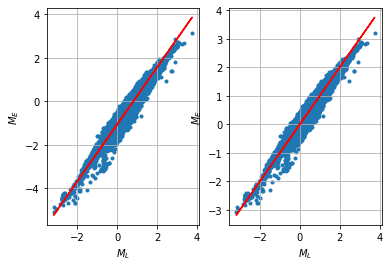

In [130]:
m, c = fit_ME_to_ML(magcat['magA'],magcat['magE'])

## 2.2 Fitting just the VTs

Got 6262 events
Fit: ME = 1.109 * ML + -1.287
After applying fit: ME2 = 1.000 * ML + -0.000
Correct formula: ME = log10(Eseismic)/1.66 - 2.18
Got 6262 events
Fit: ME = 0.999 * ML + 0.005
After applying fit: ME2 = 1.000 * ML + 0.000


/Users/gt/opt/anaconda3/envs/AAA/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


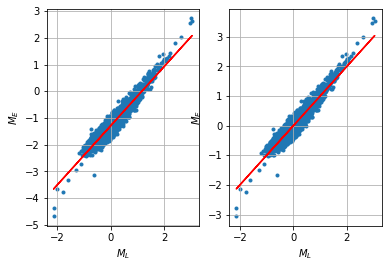

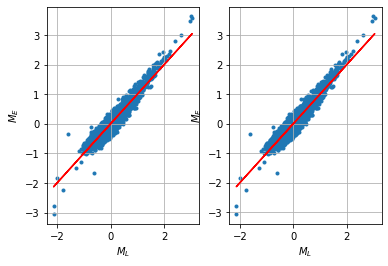

In [131]:
cat_vte = magcat[magcat['new_subclass']=='t']
m, c = fit_ME_to_ML(cat_vte['magA'],cat_vte['magE'])
true_slope = (1.5*m) # 1.5 is slope from Eseismic2magnitude
true_correction = (3.7 + c)/m # 3.7 is correction from Eseismic2magnitude
print('Correct formula: ME = log10(Eseismic)/%.2f - %.2f' % (true_slope, true_correction))

def compute_magE2(df, true_slope, true_correction):   
    df['magE2'] = np.log10(df['Eseismic'])/true_slope - true_correction
    
compute_magE2(cat_vte, true_slope, true_correction)
m, c = fit_ME_to_ML(cat_vte['magA'],cat_vte['magE2'])

## 2.3 Fitting rockfalls
What we want to do here is a different type of fit. 
We want to compute ME2 in the same way as we did for VTs, because we have now determined this is the best formula for magnitudes in general, and it fits the new ME2 scale to the ML scale. But then we want to study the mapping between ME2 and ML for rockfalls, and see if there is a different slope and constant. That will tell us something about how ML overestimates or underestimates ME2, which should be related to the shape of rockfall signals.

Got 107879 events
Fit: ME = 1.330 * ML + -1.000
After applying fit: ME2 = 1.000 * ML + -0.000
Correct formula for ROC only: ME = log10(Eseismic)/2.00 - 2.03
Got 107879 events
Fit: ME = 1.184 * ML + 0.271
After applying fit: ME2 = 1.000 * ML + 0.000


/Users/gt/opt/anaconda3/envs/AAA/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


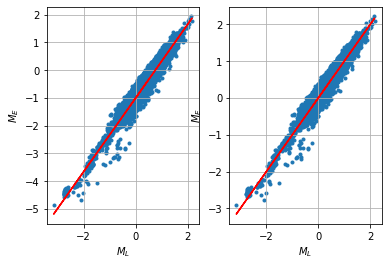

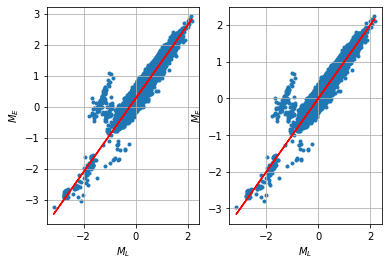

In [132]:
cat_roc = magcat[magcat['new_subclass']=='r']
m, c = fit_ME_to_ML(cat_roc['magA'],cat_roc['magE'])
true_slope_roc = (1.5*m) # 1.5 is slope from Eseismic2magnitude
true_correction_roc = (3.7 + c)/m # 3.7 is correction from Eseismic2magnitude

# true relation between Eseismic and ME for rockfalls, with ME fixed to ML for VTs
print('Correct formula for ROC only: ME = log10(Eseismic)/%.2f - %.2f' % (true_slope_roc, true_correction_roc))

# yes, here we really do intend to use the true slope and correction from VTs, not rockfalls
compute_magE2(cat_roc, true_slope, true_correction) 

# now when we fit, we see true relation between ME and ML
m, c = fit_ME_to_ML(cat_roc['magA'],cat_roc['magE2']) 

## 2.4 Generalizing this to all event subclasses

 
 *** Processing subclass = r ***
Got 107879 events
Fit: ME = 1.330 * ML + -1.000
After applying fit: ME2 = 1.000 * ML + -0.000
Correct formula for this subclass only: ME = log10(Eseismic)/2.00 - 2.03
Got 107879 events
Fit: ME = 1.184 * ML + 0.271
After applying fit: ME2 = 1.000 * ML + 0.000
 
 *** Processing subclass = e ***
Got 10290 events
Fit: ME = 1.364 * ML + -1.004
After applying fit: ME2 = 1.000 * ML + -0.000
Correct formula for this subclass only: ME = log10(Eseismic)/2.05 - 1.98
Got 10290 events
Fit: ME = 1.223 * ML + 0.267
After applying fit: ME2 = 1.000 * ML + -0.000
 
 *** Processing subclass = l ***
Got 18375 events
Fit: ME = 1.310 * ML + -1.130
After applying fit: ME2 = 1.000 * ML + 0.000
Correct formula for this subclass only: ME = log10(Eseismic)/1.96 - 1.96
Got 18375 events
Fit: ME = 1.172 * ML + 0.154
After applying fit: ME2 = 1.000 * ML + 0.000
 
 *** Processing subclass = h ***
Got 39546 events
Fit: ME = 1.269 * ML + -1.170
After applying fit: ME2 = 1.000 * ML + -

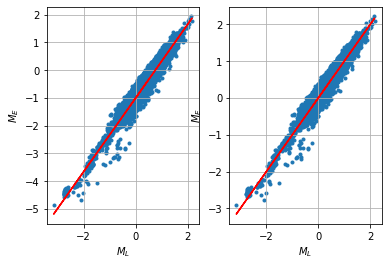

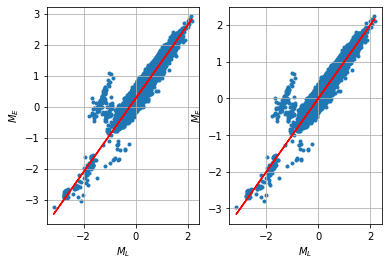

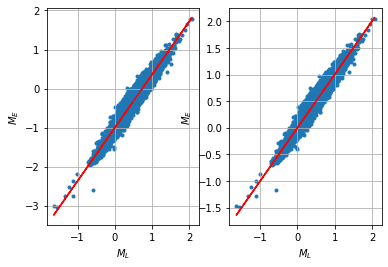

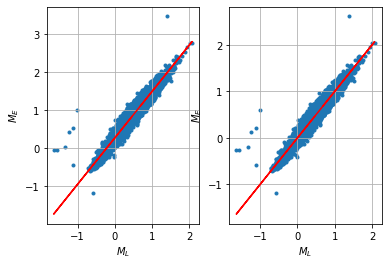

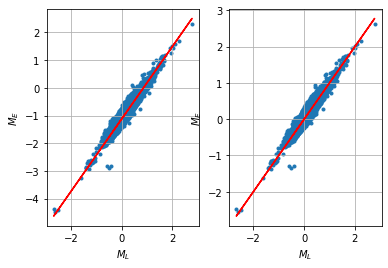

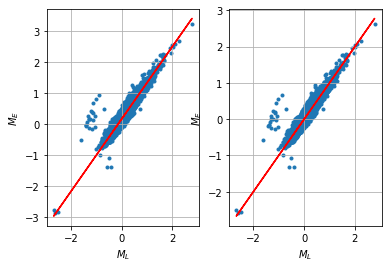

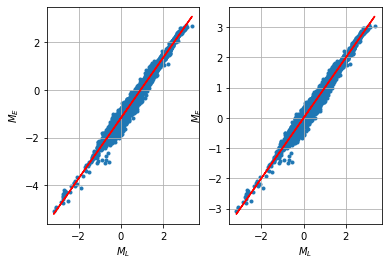

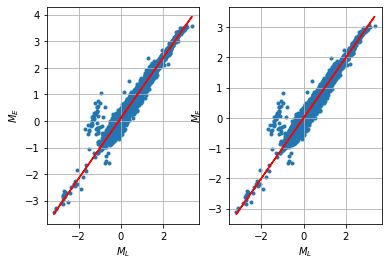

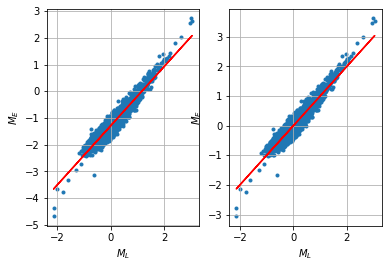

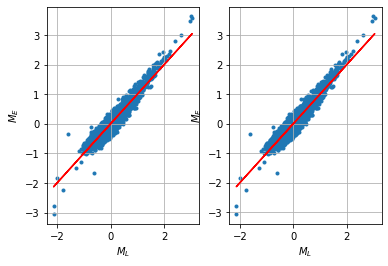

In [133]:
import warnings
warnings.filterwarnings('ignore')

def compute_best_ME_fits_for_subclass(magcat, subclass, true_slope, true_correction):
    subclass_cat = magcat[magcat['new_subclass']==subclass]
    m, c = fit_ME_to_ML(subclass_cat['magA'],subclass_cat['magE'])
    true_slope_subclass = (1.5*m) # 1.5 is slope from Eseismic2magnitude
    true_correction_subclass = (3.7 + c)/m # 3.7 is correction from Eseismic2magnitude

    # true relation between Eseismic and ME for this subclass, with ME fixed to ML for VTs
    print('Correct formula for this subclass only: ME = log10(Eseismic)/%.2f - %.2f' % (true_slope_subclass, true_correction_subclass))

    # yes, here we really do intend to use the true slope and correction from VTs, not this subclass
    compute_magE2(subclass_cat, true_slope, true_correction) 

    # now when we fit, we see true relation between ME and ML
    m, c = fit_ME_to_ML(subclass_cat['magA'], subclass_cat['magE2']) 
    
for subclass in ['r','e','l','h','t']:
    print(' ')
    print(' *** Processing subclass = %s ***' % subclass)
    compute_best_ME_fits_for_subclass(magcat, subclass, true_slope, true_correction)

# 3. Magnitude analysis by Trace ID

The catalog does not include station magnitudes (i.e. computed for each Trace). It only contains median values for peakA, Eseismic, ML and ME. So if we want to discover potential station corrections, we need to load the event CSV files instead. This is a huge dataset! Let's see if we can load all of them at once.

### The following code is way to slow. Instead, see make_alltraces_csvfiles.py, which uses Linux cat, sort and uniq commands instead. Way faster!

In [ ]:
import os
import sys
from glob import glob
import pandas as pd
LIBpath = os.path.join( os.getenv('HOME'),'src','kitchensinkGT', 'LIB')
sys.path.append(LIBpath)
from libSeisan2Pandas import set_globals
SEISAN_DATA, SEISAN_DB, station_locationsDF, MASTER_INV, bool_overwrite = set_globals()
if not isinstance(station_locationsDF, pd.DataFrame):
    print('Station coordinates not loaded. Exiting. Although we could change code and get these from StationXML file')
    exit() 
    
# Make the monthly all_traces PD files
# NOTE: would be faster to do this wit:
#   os.system("cat *.csv | uniq > all_traces_YYYYMM.csv")
# directly on newton  
yeardirs = sorted(glob(os.path.join(SEISAN_DATA, 'miniseed_c',SEISAN_DB,'[12]???')))
for yeardir in yeardirs:
    print(yeardir)
    YYYY = os.path.basename(yeardir)
    monthsdirs = sorted(glob(os.path.join(yeardir,'[01]?')))
    for monthdir in monthsdirs:
        MM = os.path.basename(monthdir)
        print(monthdir)    
        list_of_df_for_this_month = []
        csvfiles = glob(os.path.join(monthdir, '*.csv'))
        for csvfile in csvfiles:
            list_of_df_for_this_month.append(pd.read_csv(csvfile))
        df_this_month = pd.concat(list_of_df_for_this_month, sort=True)
        df_this_month.to_pickle('all_traces_%s%s.pd' % (YYYY,MM))
        

# Make the full all_traces PD file
all_monthlydf_list = []
monthlyPDfiles = glob('all_traces_??????.pd')
for thisfile in monthlyPDfiles:
    df = pd.read_pickle(thisfile)
    all_monthlydf_list.append(df)
all_traces_df = pd.concat(all_monthlydf_list, sort=True)
all_traces_df.to_pickle('all_traces_df.pd')    
    

/Users/gt/DATA/MVO/miniseed_c/MVOE_/1996
/Users/gt/DATA/MVO/miniseed_c/MVOE_/1996/10
/Users/gt/DATA/MVO/miniseed_c/MVOE_/1996/11
/Users/gt/DATA/MVO/miniseed_c/MVOE_/1996/12


# Now we just need to load alltraces.csv instead on newton under the miniseed_c/MVOE_ directory.

# We should also do b-value analysis, and determine the magnitude of completeness

In [95]:
alltracesdf = pd.read_csv('/Users/gt/DATA/MVO/miniseed_c/MVOE_/alltraces.csv')

/Users/gt/src/kitchensinkGT/PROJECTS/MontserratML


/Users/gt/opt/anaconda3/envs/AAA/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (2,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [96]:
alltracesdf.to_pickle('all_traces_df.pd')

In [100]:
occur = alltracesdf.groupby(['id']).size()
display(occur)

id
1996-10-23T16:08:00.040000Z    18
1996-10-23T20:07:11.040000Z    20
1996-10-23T22:35:49.040000Z    20
1996-10-23T23:42:17.040000Z    20
1996-10-23T23:51:04.040000Z    20
                               ..
2008-08-31T12:54:18.000000Z    25
2008-08-31T15:01:17.000000Z    25
2008-08-31T20:50:24.000000Z    25
2008-08-31T23:22:30.000000Z    25
starttime                       2
Length: 209102, dtype: int64

In [99]:
alltracesdf.columns

Index(['id', 'starttime', 'Fs', 'calib', 'units', 'quality', 'medianF',
       'peakF', 'peakA', 'bw_min', 'bw_max', 'snr', 'signal_level',
       'noise_level', 'peakamp', 'peaktime', 'energy', 'sample_min',
       'sample_max', 'sample_mean', 'sample_median', 'sample_lower_quartile',
       'sample_upper_quartile', 'sample_rms', 'sample_stdev',
       'percent_availability', 'num_gaps', 'skewness', 'kurtosis',
       'bandratio_[1.0_6.0_11.0]', 'bandratio_[0.8_4.0_16.0]', 'lon', 'lat',
       'elev', 'R', 'magA', 'Eseismic', 'magE'],
      dtype='object')

In [105]:
toprows = alltracesdf.iloc[0:10]

In [107]:
print(toprows[['id']])

                                       id
id                              starttime
id                              starttime
MV.MBBE..BHE  1996-10-23T20:07:11.040000Z
MV.MBBE..BHE  1996-10-23T22:35:49.040000Z
MV.MBBE..BHE  1996-10-23T23:42:17.040000Z
MV.MBBE..BHE  1996-10-23T23:51:04.040000Z
MV.MBBE..BHE  1996-10-23T23:59:24.040000Z
MV.MBBE..BHE  1996-10-24T00:38:04.040000Z
MV.MBBE..BHE  1996-10-24T02:06:50.040000Z
MV.MBBE..BHE  1996-10-24T02:17:54.040000Z


### this exercise is going to be harder than I thought because there are 3 different header rows
### these differ in whether 'twin' exists, and where it appears. So the traceCSV files will also have 
### this mixture. Can only fix it by adding twin to all (need to process waveform data), or drop it from all (easier)
### might choose the latter - or use detection catalog - because want to compute duration magnitude too
### and compute Montserrat ML scale constants